In [2]:
import folium
import pandas as pd
import h3
from shapely.geometry import Polygon, Point
import shapely.wkt
from geojson import Point, Feature, FeatureCollection, dump
import os
import matplotlib.pyplot as plt

# Create a GeoJson

### First find all used hexagons

In [4]:
#Get this file from scibo
df = pd.read_csv('sharenow_supply_data_6mo.csv')

df_StartEnd = df[['hex_start_7','hex_end_7']]

list_StartUnique = list(df['hex_start_7'].unique())
list_EndUnique = list(df['hex_end_7'].unique())
list_UniqueHexs = list(pd.Series(list_StartUnique+list_EndUnique).unique())

### Now get the cornerstones

In [6]:
def output_h3_id_attributes(h3_id):
    return Polygon(h3.h3_to_geo_boundary(h3_id, geo_json=True))

In [8]:
features = []
for hexID in list_UniqueHexs:
    features.append(Feature(geometry=output_h3_id_attributes(hexID), properties={"hexID": hexID}))

feature_collection = FeatureCollection(features)

with open('berlin_charger.geojson', 'w') as f:
   dump(feature_collection, f)

# Visualise on map

In [10]:
map = folium.Map(location=[52.518839, 13.399304], default_zoom_start=30)

In [12]:
chargerPerHex = pd.read_csv('charger_in_hex.csv')
dfHexIds = pd.read_csv('scenarios_multinomial_4.csv')

chargerPerHex['hexID'] = list(dfHexIds.columns.drop('probs'))


finalData = chargerPerHex[['hexID']]
chargerPerHex = chargerPerHex[['x1','x2','x3']].sum(axis=1)
finalData['charger'] = chargerPerHex

finalData.head(5)

,hexID,charger
0,871f18840ffffff,3.0
1,871f18841ffffff,1.0
2,871f18868ffffff,0.0
3,871f18869ffffff,8.0
4,871f1886affffff,0.0


In [14]:
#Avoid black points 
#Get all hex ids

for id in list_StartUnique:
    if id not in finalData['hexID'].unique():
        finalData = finalData.append({'hexID':id,'charger':0},ignore_index=True)



In [16]:
map.choropleth(geo_data="berlin_charger.geojson",
             data=finalData, 
             columns=['hexID', 'charger'], 
             key_on='feature.properties.hexID', 
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Charger')
map

## Sensitivities

In [18]:
plt.style.use('seaborn')
figsize = (16,9)

## Opportunity Cost

In [20]:
path = "./sensitivity/opportunity/"
df_charger_opc = pd.DataFrame()
df_E_not_supplied_opc = pd.DataFrame()

for file in os.listdir(path):
    if "charger" in file:
        df_charger_opc["op_cost_"+file.split("_")[-1].split(".c")[0]] = \
            pd.read_csv((path+file)).sum()

    elif "E_not_supplied" in file:
        df_E_not_supplied_opc["op_cost_"+file.split("_")[-1].split(".c")[0]] = \
            pd.read_csv((path+file)).sum()

    elif "cost_dict" in file:
        df_cost_opc = pd.read_csv((path+file))
        df_cost_opc.columns = ["Opportunity Cost", "Total Cost"]
        df_cost_opc.set_index("Opportunity Cost", inplace=True)
        df_cost_opc.sort_index(inplace=True)
        
    elif "cvar_dict" in file:
        df_cvar_opc = pd.read_csv((path+file))
        df_cvar_opc.columns = ["Opportunity Cost", "cvar"]
        df_cvar_opc.set_index("Opportunity Cost", inplace=True)
        df_cvar_opc.sort_index(inplace=True)
        
    elif "E_supplied" in file:
        df_E_supplied_opc = pd.read_csv((path+file))
        df_E_supplied_opc.columns = ["Opportunity Cost", "Energy Supplied"]
        df_E_supplied_opc.set_index("Opportunity Cost", inplace=True)
        df_E_supplied_opc.sort_index(inplace=True)
        
    elif "cars_supplied" in file:
        df_cars_supplied_opc = pd.read_csv((path+file))
        df_cars_supplied_opc.columns = ["Opportunity Cost", "Cars Supplied"]
        df_cars_supplied_opc.set_index("Opportunity Cost", inplace=True)
        df_cars_supplied_opc.sort_index(inplace=True)

In [22]:
df_cars_supplied_opc

,Cars Supplied
Opportunity Cost,
0.1,0.0
0.2,0.0
0.3,5112.0
0.4,9956.0
0.5,12876.0
0.6,15449.0
0.7,15750.0
0.8,15750.0
0.9,15750.0


In [24]:
df_E_supplied_opc

,Energy Supplied
Opportunity Cost,
0.1,0.0
0.2,0.0
0.3,101947.5
0.4,198324.0
0.5,256374.0
0.6,307975.5
0.7,313614.0
0.8,313614.0
0.9,313614.0


In [26]:
df_opc = pd.DataFrame(df_E_supplied_opc["Energy Supplied"]/df_cars_supplied_opc["Cars Supplied"])
df_opc.columns = ["Energy per car"]
#df_opc.plot(kind="bar")
df_opc

,Energy per car
Opportunity Cost,
0.1,NaN
0.2,NaN
0.3,19.942782
0.4,19.920048
0.5,19.910997
0.6,19.934980
0.7,19.912000
0.8,19.912000
0.9,19.912000


<AxesSubplot:title={'center':'Number of chargers installed'}>

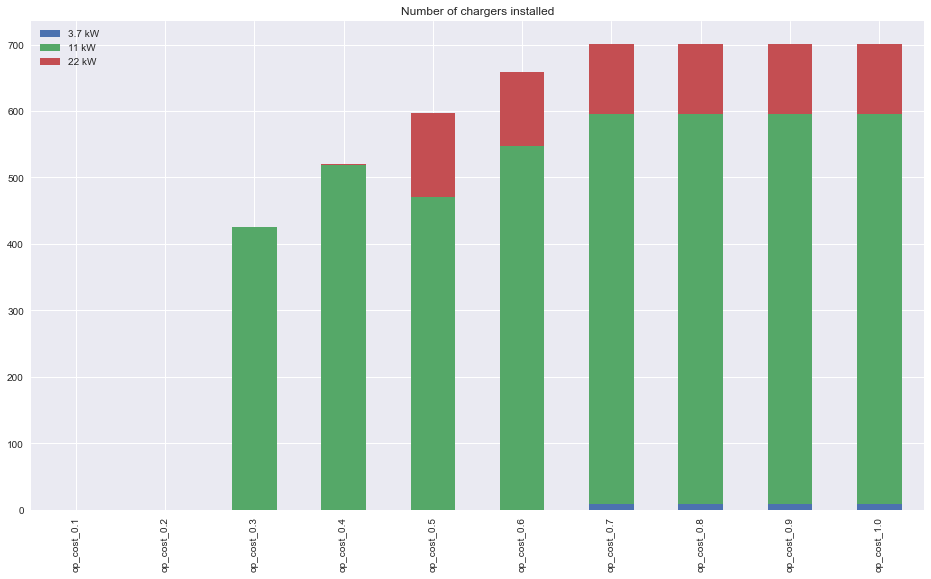

In [28]:
df_charger_opc.index = ["3.7 kW", "11 kW", "22 kW"]
df_charger_opc.T.plot(kind="bar", stacked=True, figsize = figsize, title="Number of chargers installed")

<AxesSubplot:title={'center':'Number of chargers installed'}>

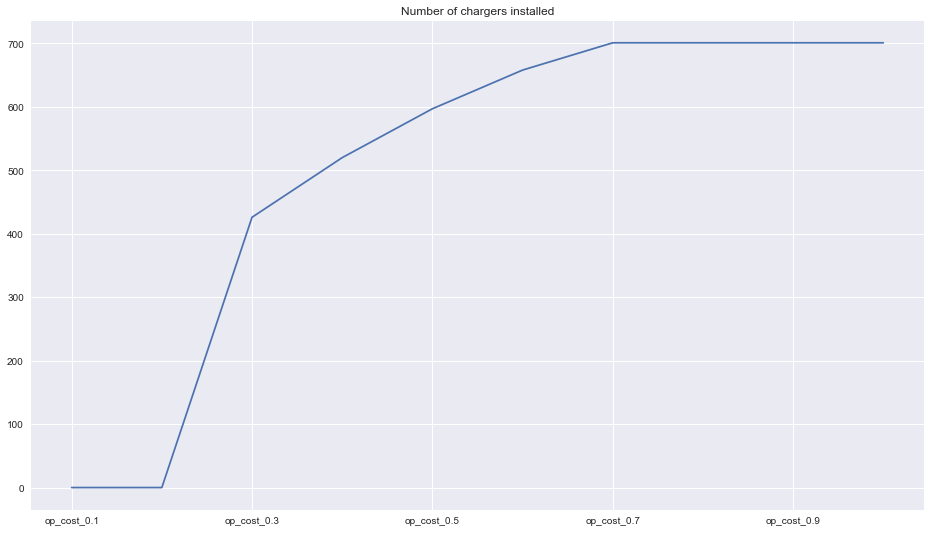

In [30]:
df_charger_opc.sum().plot(figsize = figsize, title="Number of chargers installed")

<AxesSubplot:title={'center':'Energy not supplied'}>

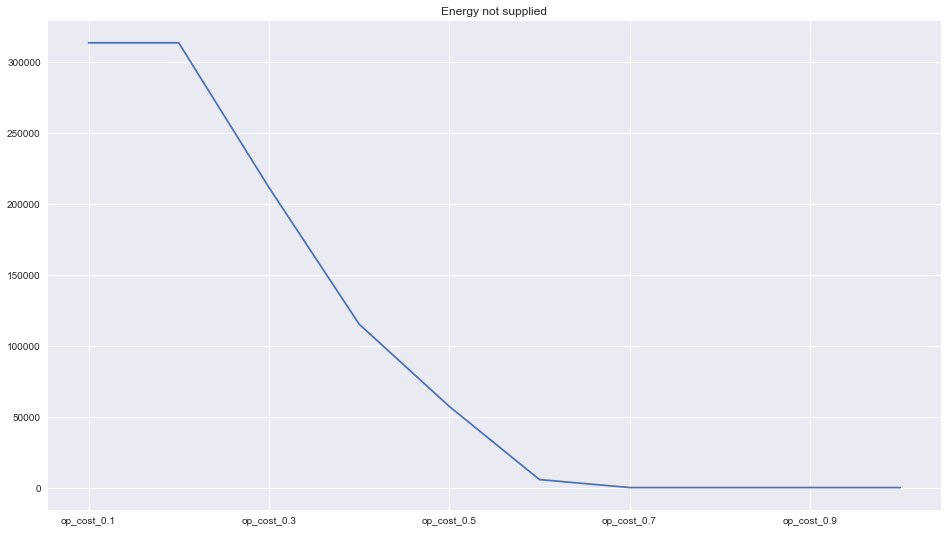

In [32]:
df_E_not_supplied_opc.sum().plot(title="Energy not supplied", figsize = figsize)

<AxesSubplot:title={'center':'Total cost'}, xlabel='Opportunity Cost'>

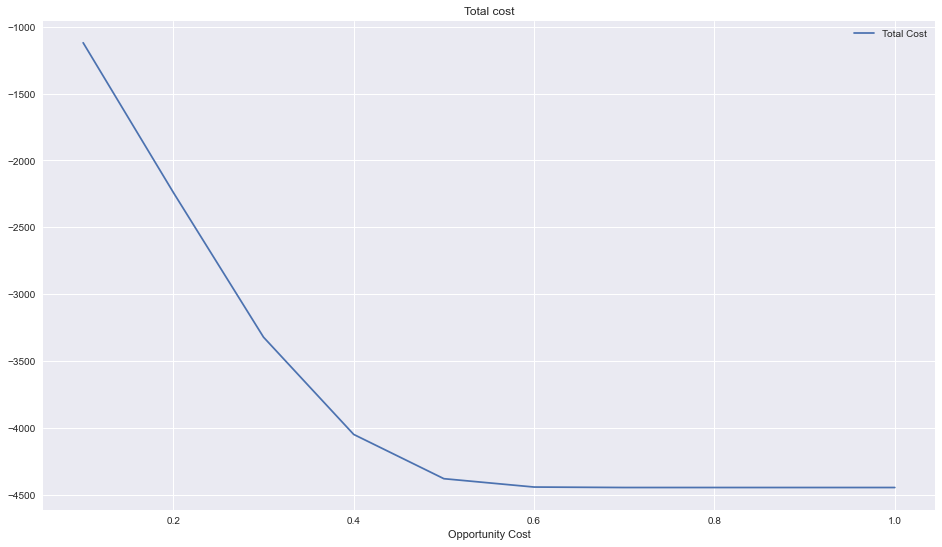

In [34]:
df_cost_opc.plot(title="Total cost", figsize = figsize)

<AxesSubplot:title={'center':'Cvar'}, xlabel='Opportunity Cost'>

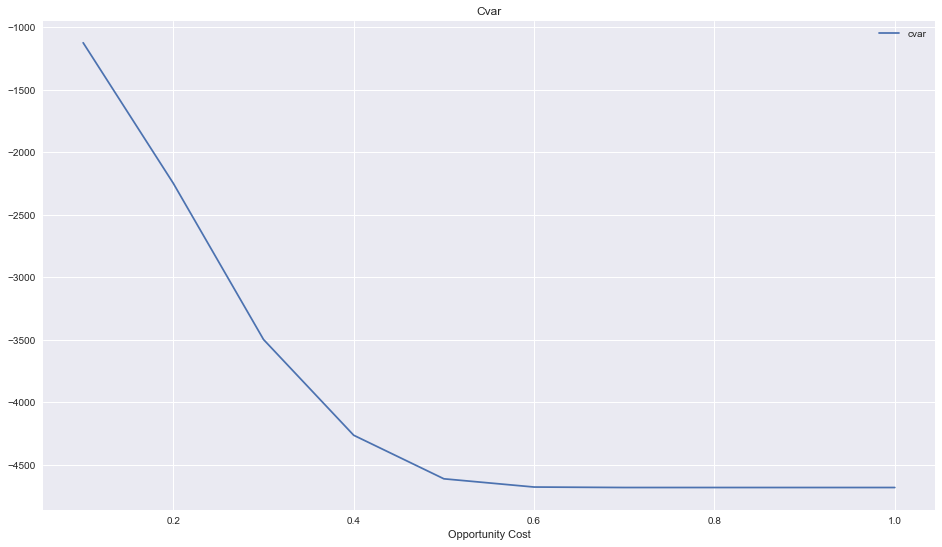

In [36]:
df_cvar_opc.plot(title="Cvar", figsize = figsize)

### Beta

In [38]:
path = "./sensitivity/beta/"
df_charger_beta = pd.DataFrame()
df_E_not_supplied_beta = pd.DataFrame()

for file in os.listdir(path):
    if "charger" in file:
        df_charger_beta["beta_"+file.split("_")[-1].split(".c")[0]] = \
            pd.read_csv((path+file)).sum()

    elif "E_not_supplied" in file:
        df_E_not_supplied_beta["beta_"+file.split("_")[-1].split(".c")[0]] = \
            pd.read_csv((path+file)).sum()

    elif "cost_dict" in file:
        df_cost_beta = pd.read_csv((path+file))
        df_cost_beta.columns = ["Beta", "Total Cost"]
        df_cost_beta.set_index("Beta", inplace=True)
        df_cost_beta.sort_index(inplace=True)
        
    elif "cvar_dict" in file:
        df_cvar_beta = pd.read_csv((path+file))
        df_cvar_beta.columns = ["Beta", "cvar"]
        df_cvar_beta.set_index("Beta", inplace=True)
        df_cvar_beta.sort_index(inplace=True)
        
    elif "E_supplied" in file:
        df_E_supplied_beta = pd.read_csv((path+file))
        df_E_supplied_beta.columns = ["Beta", "Energy Supplied"]
        df_E_supplied_beta.set_index("Beta", inplace=True)
        df_E_supplied_beta.sort_index(inplace=True)
        
    elif "cars_supplied" in file:
        df_cars_supplied_beta = pd.read_csv((path+file))
        df_cars_supplied_beta.columns = ["Beta", "Cars Supplied"]
        df_cars_supplied_beta.set_index("Beta", inplace=True)
        df_cars_supplied_beta.sort_index(inplace=True)

In [40]:
df_cars_supplied_beta

,Cars Supplied
Beta,
0.0,15750.0
0.2,15750.0
0.4,15750.0
0.6,15750.0
0.8,15750.0
1.0,15750.0


In [42]:
df_beta = pd.DataFrame(df_E_supplied_beta["Energy Supplied"]/df_cars_supplied_beta["Cars Supplied"])
df_beta.columns = ["Energy per car"]
#df_beta.plot(kind="bar")
df_beta

,Energy per car
Beta,
0.0,19.912
0.2,19.912
0.4,19.912
0.6,19.912
0.8,19.912
1.0,19.912


<AxesSubplot:title={'center':'Number of chargers installed'}>

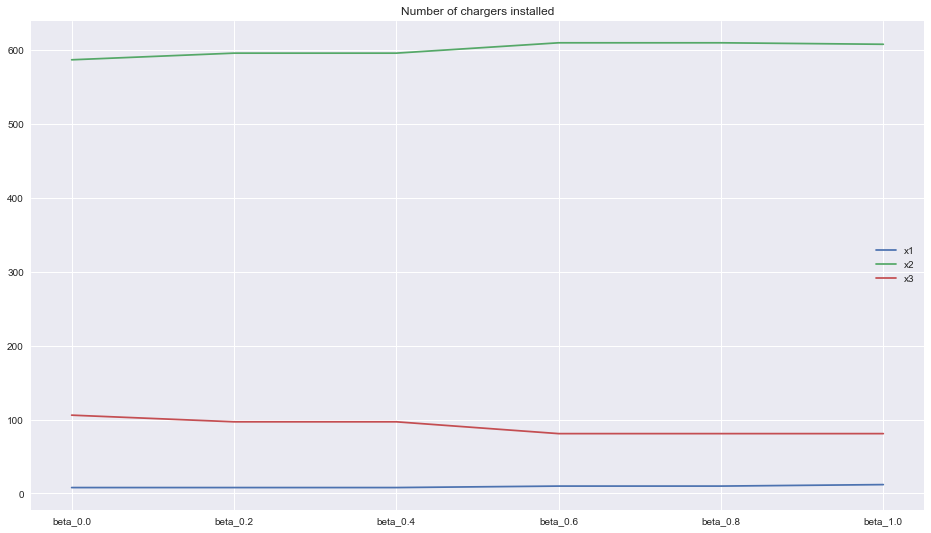

In [44]:
df_charger_beta.T.plot(figsize = figsize, title="Number of chargers installed")

In [46]:
df_charger_beta.T

,x1,x2,x3
beta_0.0,8.0,587.0,106.0
beta_0.2,8.0,596.0,97.0
beta_0.4,8.0,596.0,97.0
beta_0.6,10.0,610.0,81.0
beta_0.8,10.0,610.0,81.0
beta_1.0,12.0,608.0,81.0


<AxesSubplot:title={'center':'Number of chargers installed'}>

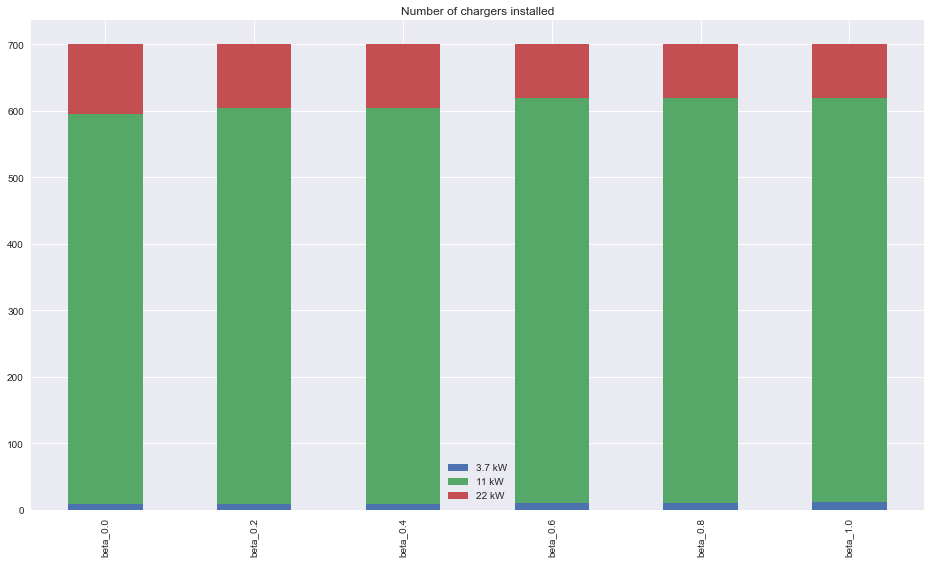

In [48]:
df_charger_beta.index = ["3.7 kW", "11 kW", "22 kW"]
df_charger_beta.T.plot(kind="bar", stacked=True, figsize = figsize, title="Number of chargers installed")

<AxesSubplot:title={'center':'Number of chargers installed'}>

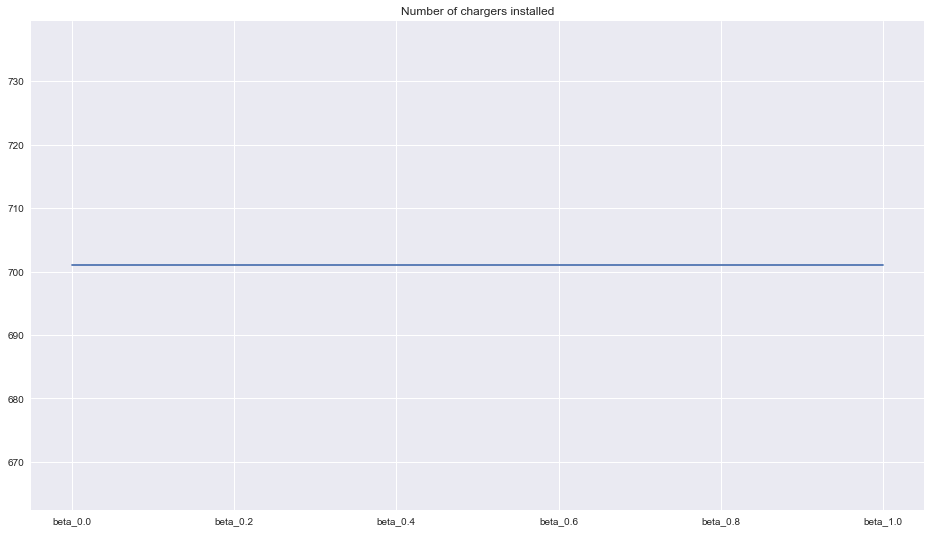

In [50]:
df_charger_beta.sum().plot(figsize = figsize, title="Number of chargers installed")

<AxesSubplot:title={'center':'Energy not supplied'}>

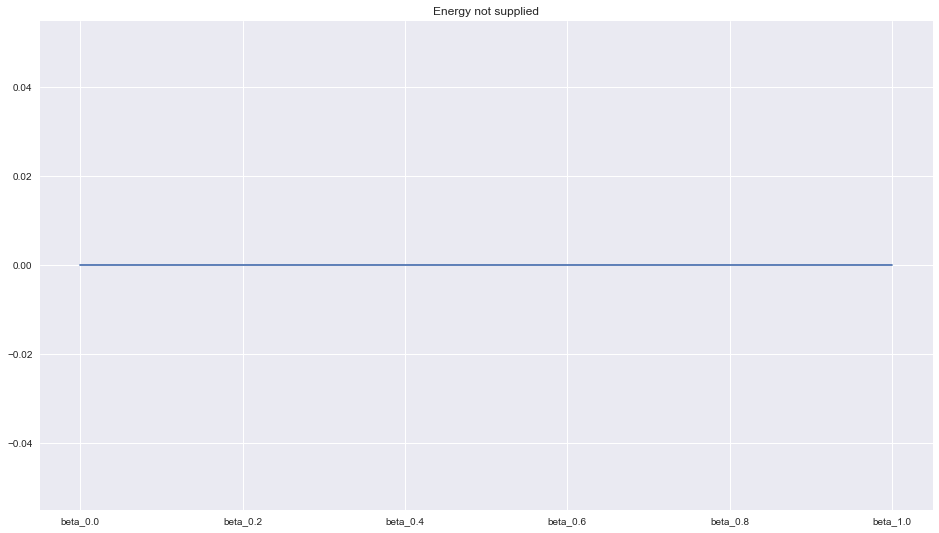

In [52]:
df_E_not_supplied_beta.sum().plot(title="Energy not supplied", figsize = figsize)

<AxesSubplot:title={'center':'Energy not supplied'}>

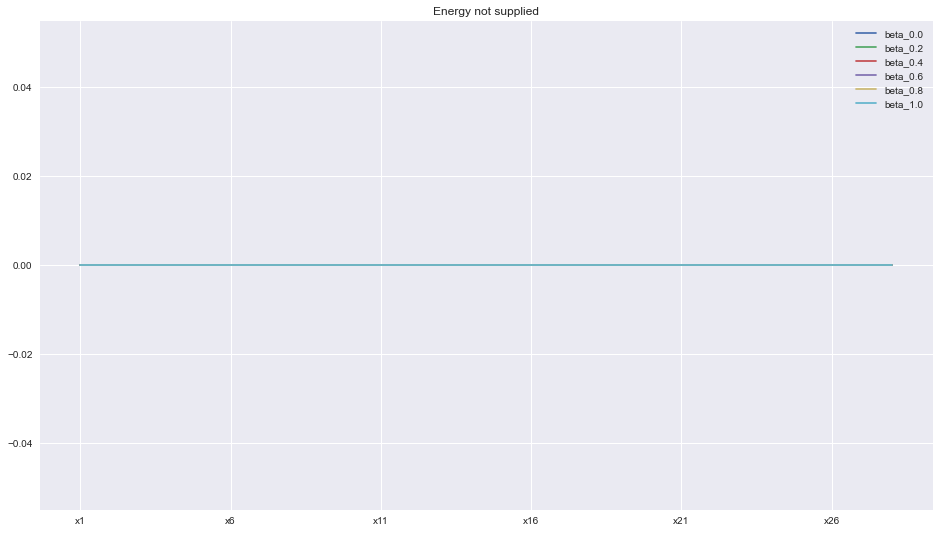

In [54]:
df_E_not_supplied_beta.plot(title="Energy not supplied", figsize = figsize)

<AxesSubplot:title={'center':'Total cost'}, xlabel='Beta'>

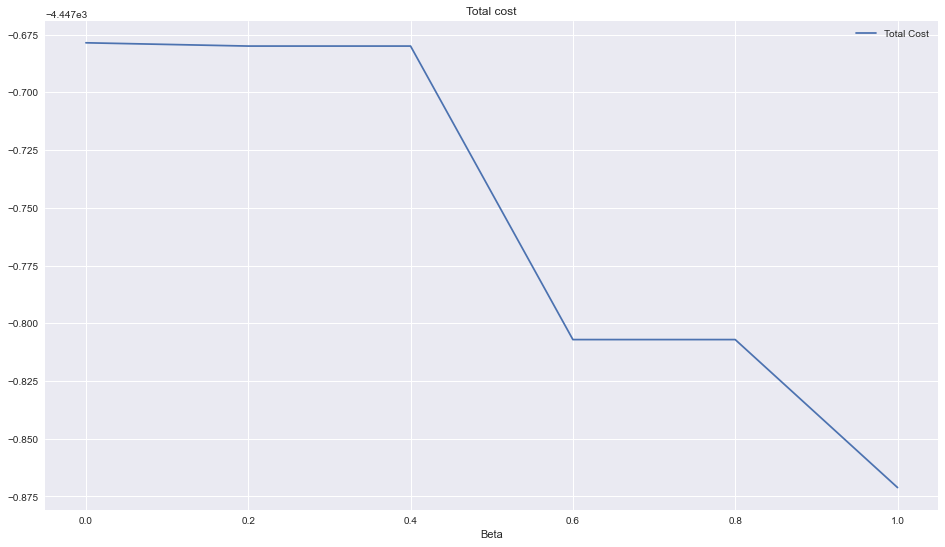

In [56]:
df_cost_beta.plot(title="Total cost", figsize = figsize)

<AxesSubplot:title={'center':'cvar'}, xlabel='Beta'>

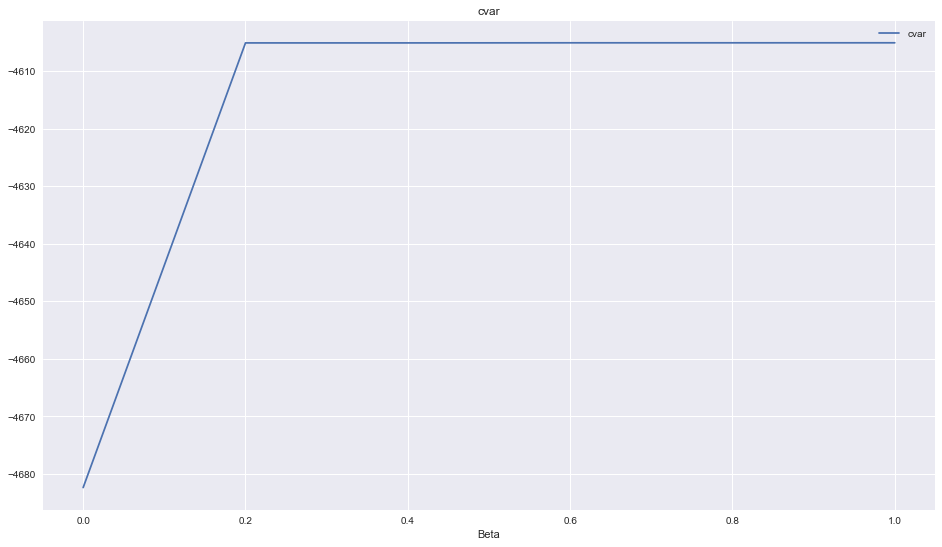

In [58]:
df_cvar_beta.plot(title="cvar", figsize = figsize)

## Charging hours

In [60]:
path = "./sensitivity/hours/"
df_charger_hours = pd.DataFrame()
df_E_not_supplied_hours = pd.DataFrame()

for file in os.listdir(path):
    if "charger" in file:
        df_charger_hours["hours_"+file.split("_")[-1].split(".c")[0]] = \
            pd.read_csv((path+file)).sum()

    elif "E_not_supplied" in file:
        df_E_not_supplied_hours["hours_"+file.split("_")[-1].split(".c")[0]] = \
            pd.read_csv((path+file)).sum()

    elif "cost_dict" in file:
        df_cost_hours = pd.read_csv((path+file))
        df_cost_hours.columns = ["Hours for charging", "Total Cost"]
        df_cost_hours.set_index("Hours for charging", inplace=True)
        df_cost_hours.sort_index(inplace=True)
        
    elif "cvar_dict" in file:
        df_cvar_hours = pd.read_csv((path+file))
        df_cvar_hours.columns = ["Hours for charging", "cvar"]
        df_cvar_hours.set_index("Hours for charging", inplace=True)
        df_cvar_hours.sort_index(inplace=True)
                
    elif "E_supplied" in file:
        df_E_supplied_hours = pd.read_csv((path+file))
        df_E_supplied_hours.columns = ["Hours for charging", "Energy Supplied"]
        df_E_supplied_hours.set_index("Hours for charging", inplace=True)
        df_E_supplied_hours.sort_index(inplace=True)
        
    elif "cars_supplied" in file:
        df_cars_supplied_hours = pd.read_csv((path+file))
        df_cars_supplied_hours.columns = ["Hours for charging", "Cars Supplied"]
        df_cars_supplied_hours.set_index("Hours for charging", inplace=True)
        df_cars_supplied_hours.sort_index(inplace=True)

In [62]:
df_hours = pd.DataFrame(df_E_supplied_hours["Energy Supplied"]/df_cars_supplied_hours["Cars Supplied"])
df_hours.columns = ["Energy per car"]
#df_hours.plot(kind="bar")
df_hours

,Energy per car
Hours for charging,
2,19.912
3,19.912
4,19.912
5,19.912
6,19.912
7,19.912


<AxesSubplot:title={'center':'Number of chargers installed'}>

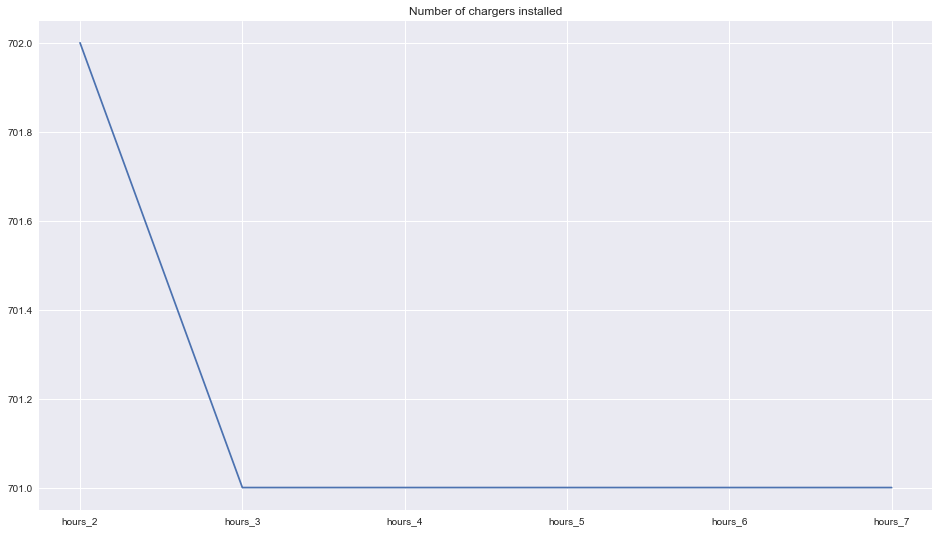

In [64]:
df_charger_hours.sum().plot(title="Number of chargers installed", figsize = figsize)

<AxesSubplot:title={'center':'Number of chargers installed'}>

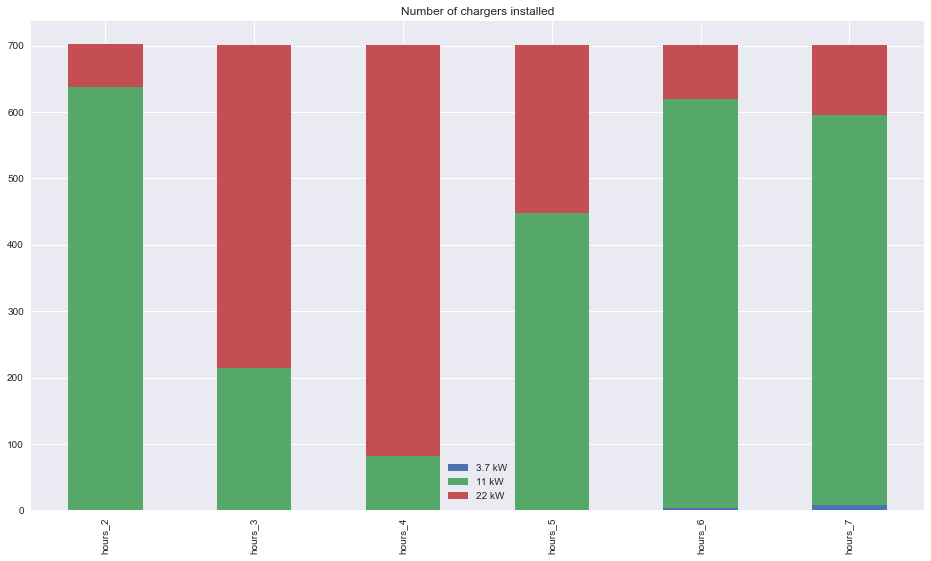

In [66]:
df_charger_hours.index = ["3.7 kW", "11 kW", "22 kW"]
df_charger_hours.T.plot(kind="bar", stacked=True, title="Number of chargers installed", figsize = figsize)

<AxesSubplot:title={'center':'Energy not supplied'}>

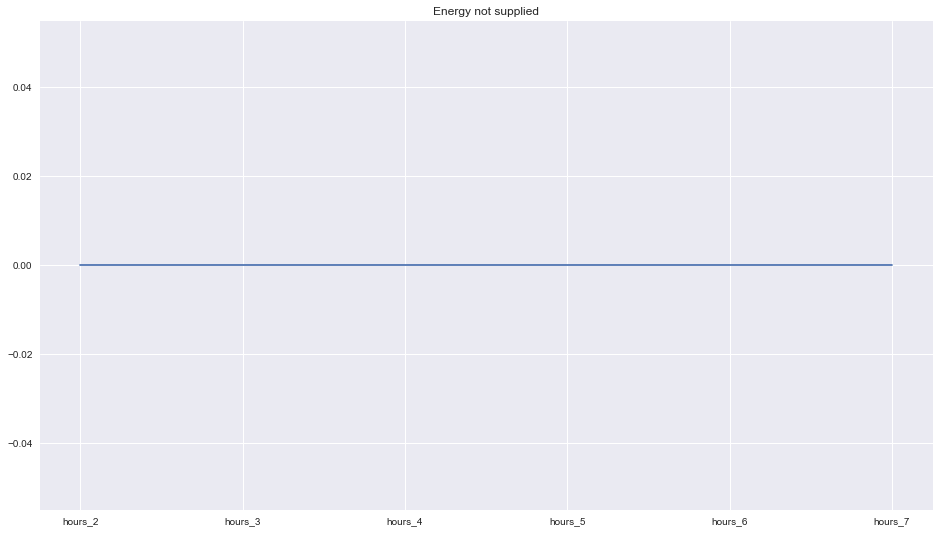

In [68]:
df_E_not_supplied_hours.sum().plot(title="Energy not supplied", figsize = figsize)

<AxesSubplot:title={'center':'Energy not supplied'}>

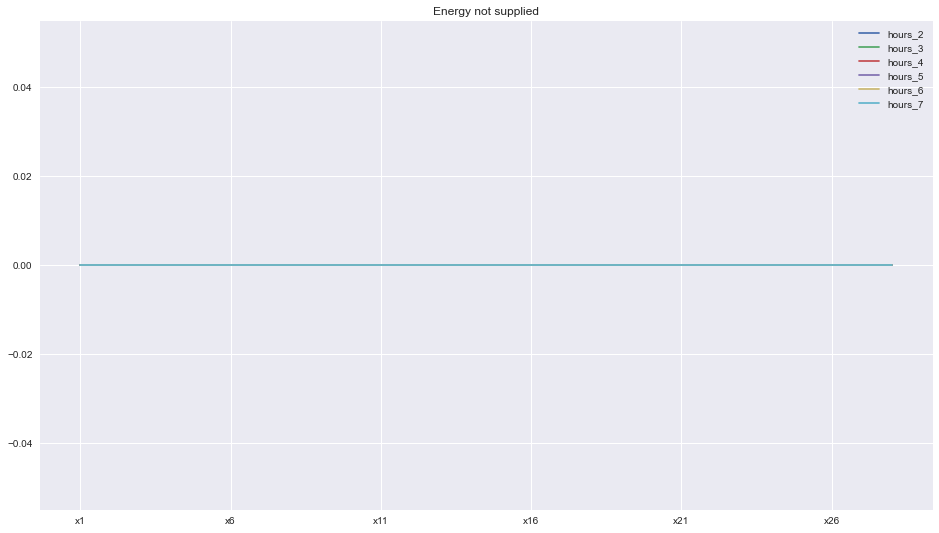

In [70]:
df_E_not_supplied_hours.plot(title="Energy not supplied", figsize = figsize)

<AxesSubplot:title={'center':'Total cost'}, xlabel='Hours for charging'>

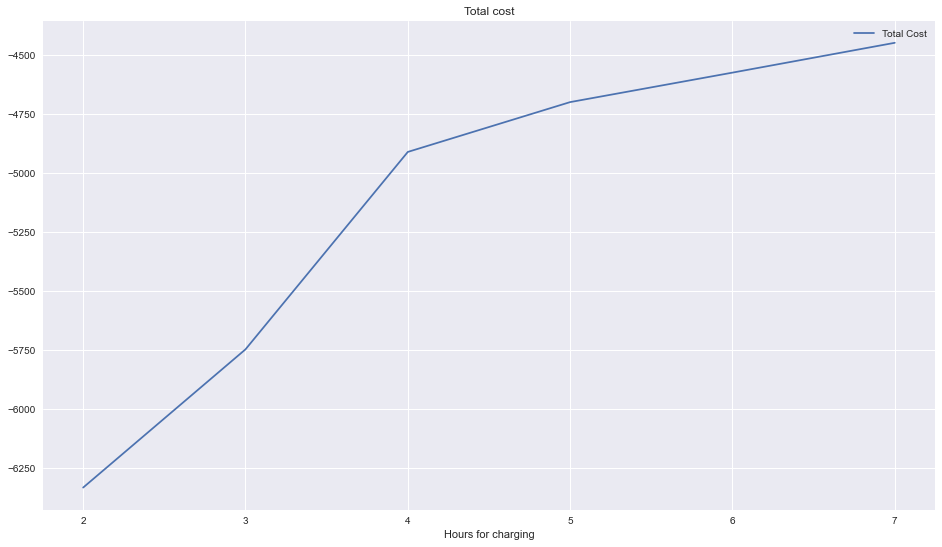

In [72]:
df_cost_hours.plot(title="Total cost", figsize = figsize)

<AxesSubplot:title={'center':'Cvar'}, xlabel='Hours for charging'>

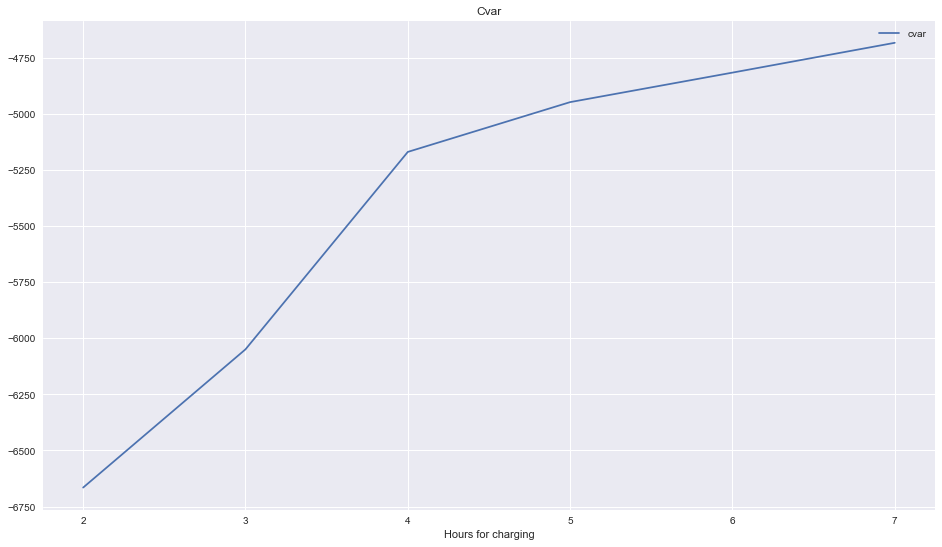

In [74]:
df_cvar_hours.plot(title="Cvar", figsize = figsize)